# Using scanpy_plus
This is not a replacement for scanpy, but a supplement to it.

It provides additional functions that make working with single cell data easier.

`scanpy_plus` installation does not have any dependencies. This is by design as installation of this package will not affect your existing environment.

However, running commands will require packages to be installed. For example, `scp.tl.run_scvi` requires scvi-tools to be installed. This is left to users to resolve

In [1]:
import scanpy as sc
import scanpy_plus as scp
import anndata as ad
import seaborn as sns
import torch
import tempfile
import scvi

/Users/vm11/Soft/scanpy_plus/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor="white")
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

/Users/vm11/Soft/scanpy_plus/venv/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


In [3]:
adata = scvi.data.heart_cell_atlas_subsampled()
adata

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'

## scanpy_plus describe function.

This function provides an extended description of the AnnData object.

Tells you what is likely state of adata.X - raw, normalized, log1p transformed, scaled.

X min and max values - Tells you if it is logged or not.

For top 100 cells it prints the total counts (min and max). Tells you if data is normalized or not

In [4]:
adata.describe()

**** Highly likely data is raw
-----
(X) min = 0.0 | max = 7468.0 
-----
(head 100 cells) umi_sum min =  529.0 | umi_sum max =  9042.0 | cellmean =   2729.3535
-----
AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'


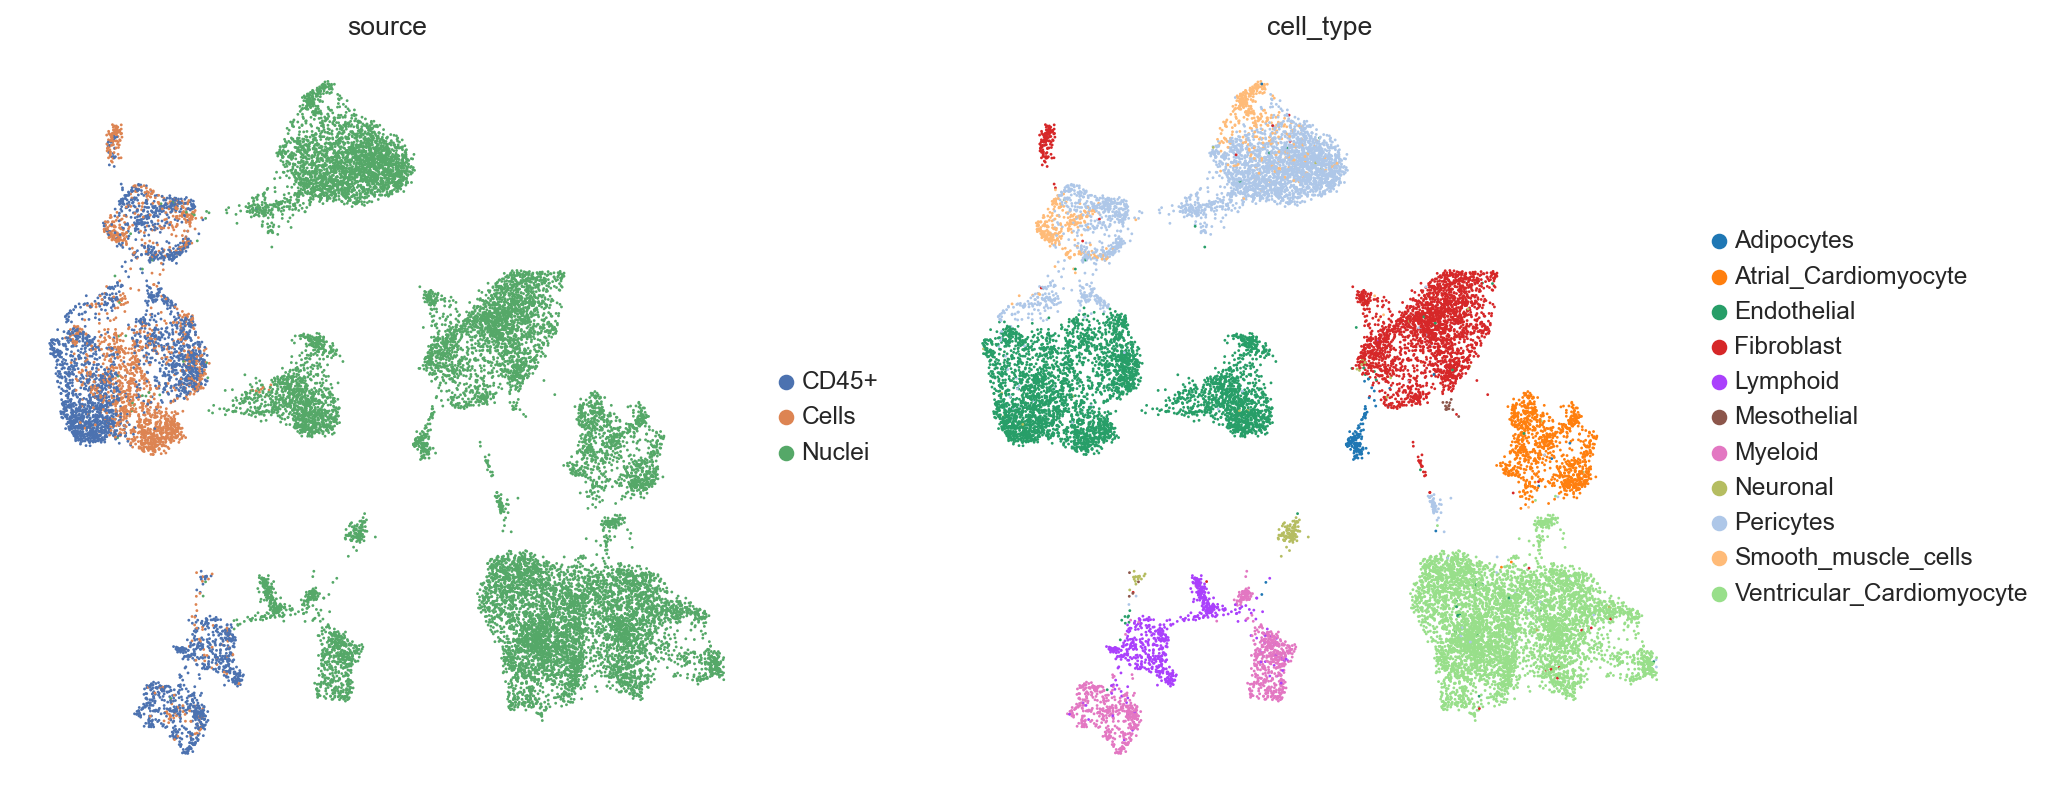

In [5]:
# General preprocessing. Not specific to scanpy_plus
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
adata.raw = adata # Generally this is not recommended for raw counts, but for simplicity in this tutorial we do it.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,  n_top_genes=2000, subset=True, batch_key="source")
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["source", "cell_type"])


# Integrate using scanpy_plus
Presently this has [scvi][ https://docs.scvi-tools.org/en/1.3.2/tutorials/notebooks/quick_start/api_overview.html ]. 

In [6]:
adata.obs['source'].value_counts()

source
Nuclei    13733
CD45+      3155
Cells      1753
Name: count, dtype: int64

In [7]:
# declare the covariates
raw_count_layer="counts"
#categorical_covariate_keys=["donor"],
continuous_covariate_keys=["percent_mito", "percent_ribo"]


Seed set to 42
/Users/vm11/Soft/scanpy_plus/scanpy_plus/tl/run_scvi.py:46: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  data.var['mt'] = data.var_names.str.startswith('MT-')
2025-11-02 19:41:06.906 | INFO     | scanpy_plus.tl.run_scvi:clean_genes:58 - Genes before removal: 2000


regev_lab_cell_cycle_genes.txt already exists. Skipping download.


2025-11-02 19:41:07.028 | INFO     | scanpy_plus.tl.run_scvi:clean_genes:61 - Genes after removal: 1988
2025-11-02 19:41:07.029 | INFO     | scanpy_plus.tl.run_scvi:run_scvi:107 - Init model
2025-11-02 19:41:07.099 | INFO     | scanpy_plus.tl.run_scvi:run_scvi:117 - Started training model
/Users/vm11/Soft/scanpy_plus/venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/vm11/Soft/scanpy_plus/venv/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/vm11

Epoch 1/1: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it, v_num=1, train_loss=1.22e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, v_num=1, train_loss=1.22e+3]

2025-11-02 19:41:08.879 | INFO     | scanpy_plus.tl.run_scvi:run_scvi:126 - Plotting ELBO loss


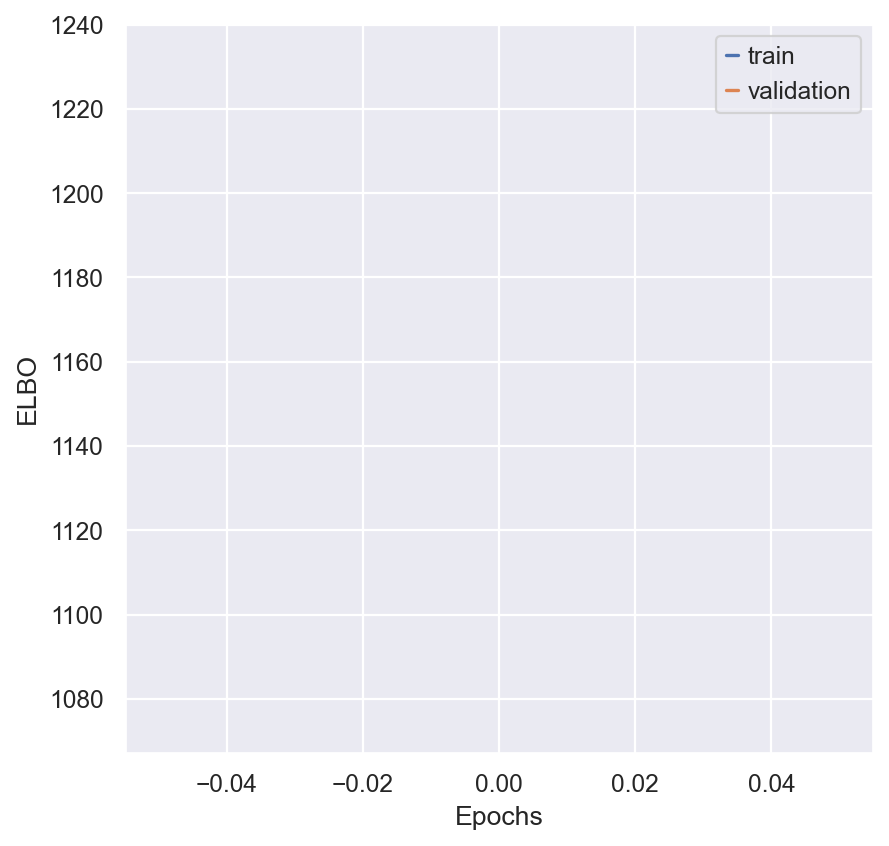

2025-11-02 19:41:08.951 | INFO     | scanpy_plus.tl.run_scvi:run_scvi:128 - Getting obsm updated. Your scvi model will be stored in X_scvi


In [10]:
adata_scvi, model = scp.tl.run_scvi(
    adata[:,adata.var.highly_variable],
    batch_key="source",
    continuous_covariate_keys = continuous_covariate_keys,
    max_epochs=1 # for tutorial purposes only
)


In [13]:
adata_scvi.obsm["X_scvi"].shape

(18641, 10)

In [14]:
sc.pp.neighbors(adata_scvi, use_rep="X_scvi")
sc.tl.umap(adata_scvi, key_added="umap_scvi")

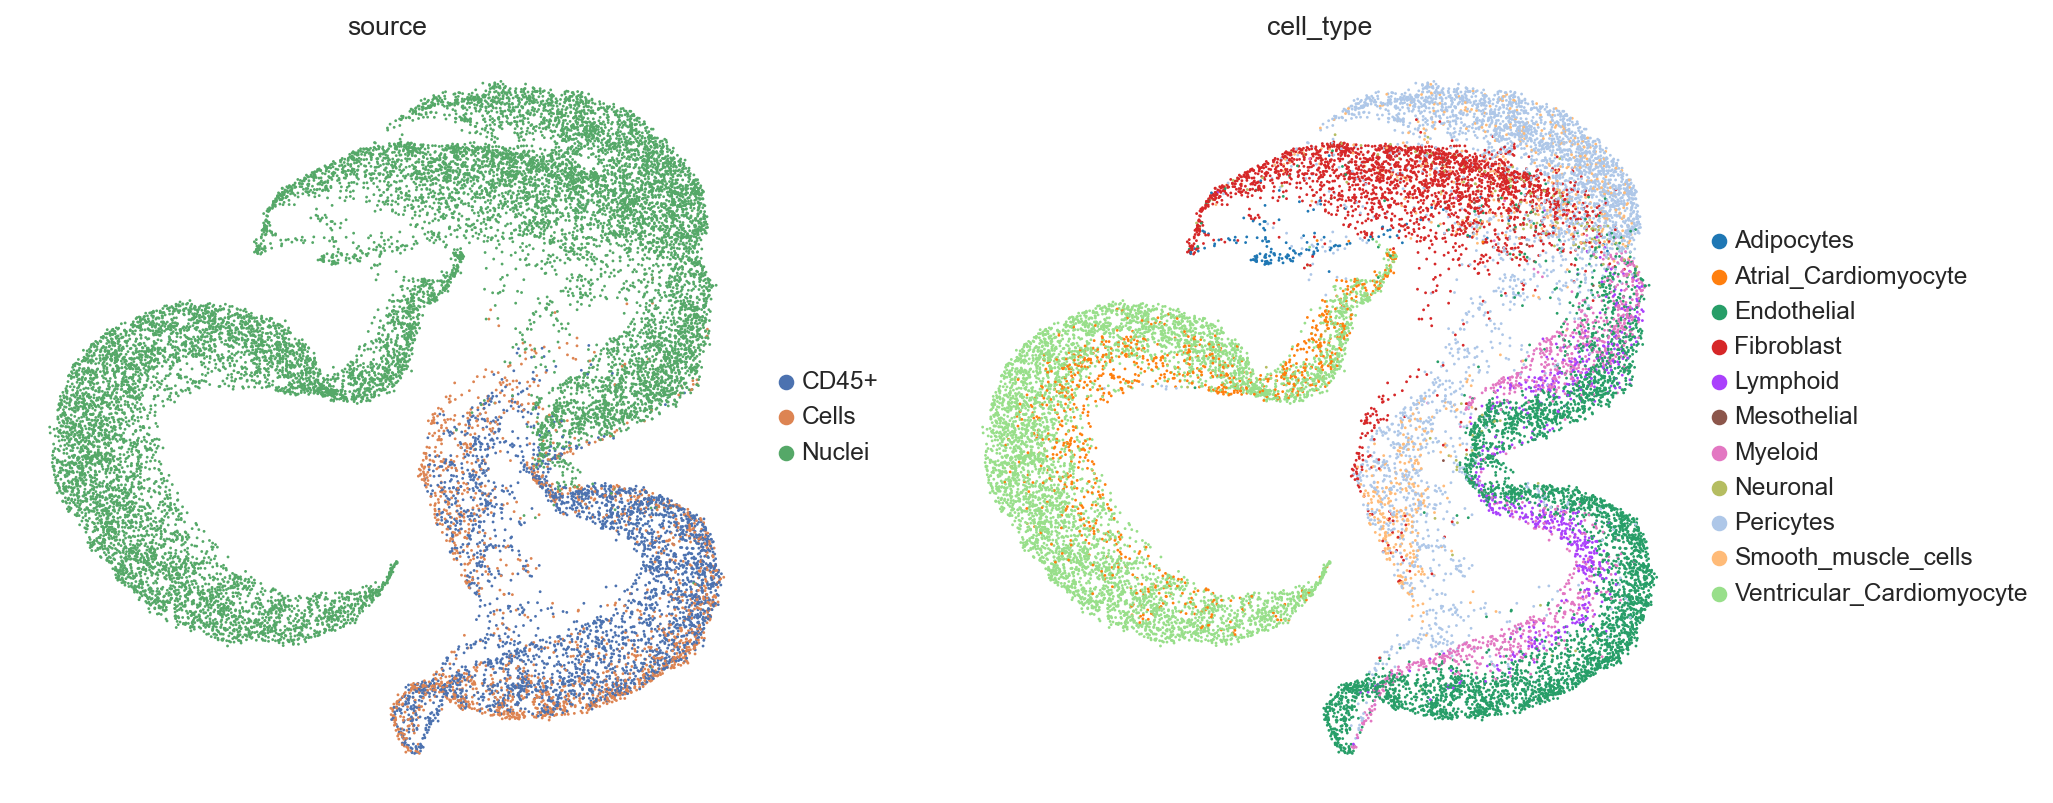

In [16]:
sc.pl.embedding(adata_scvi, basis="umap_scvi", color=["source", "cell_type"])

# Plotting functions

## splitplot
Convenient function to split your plots



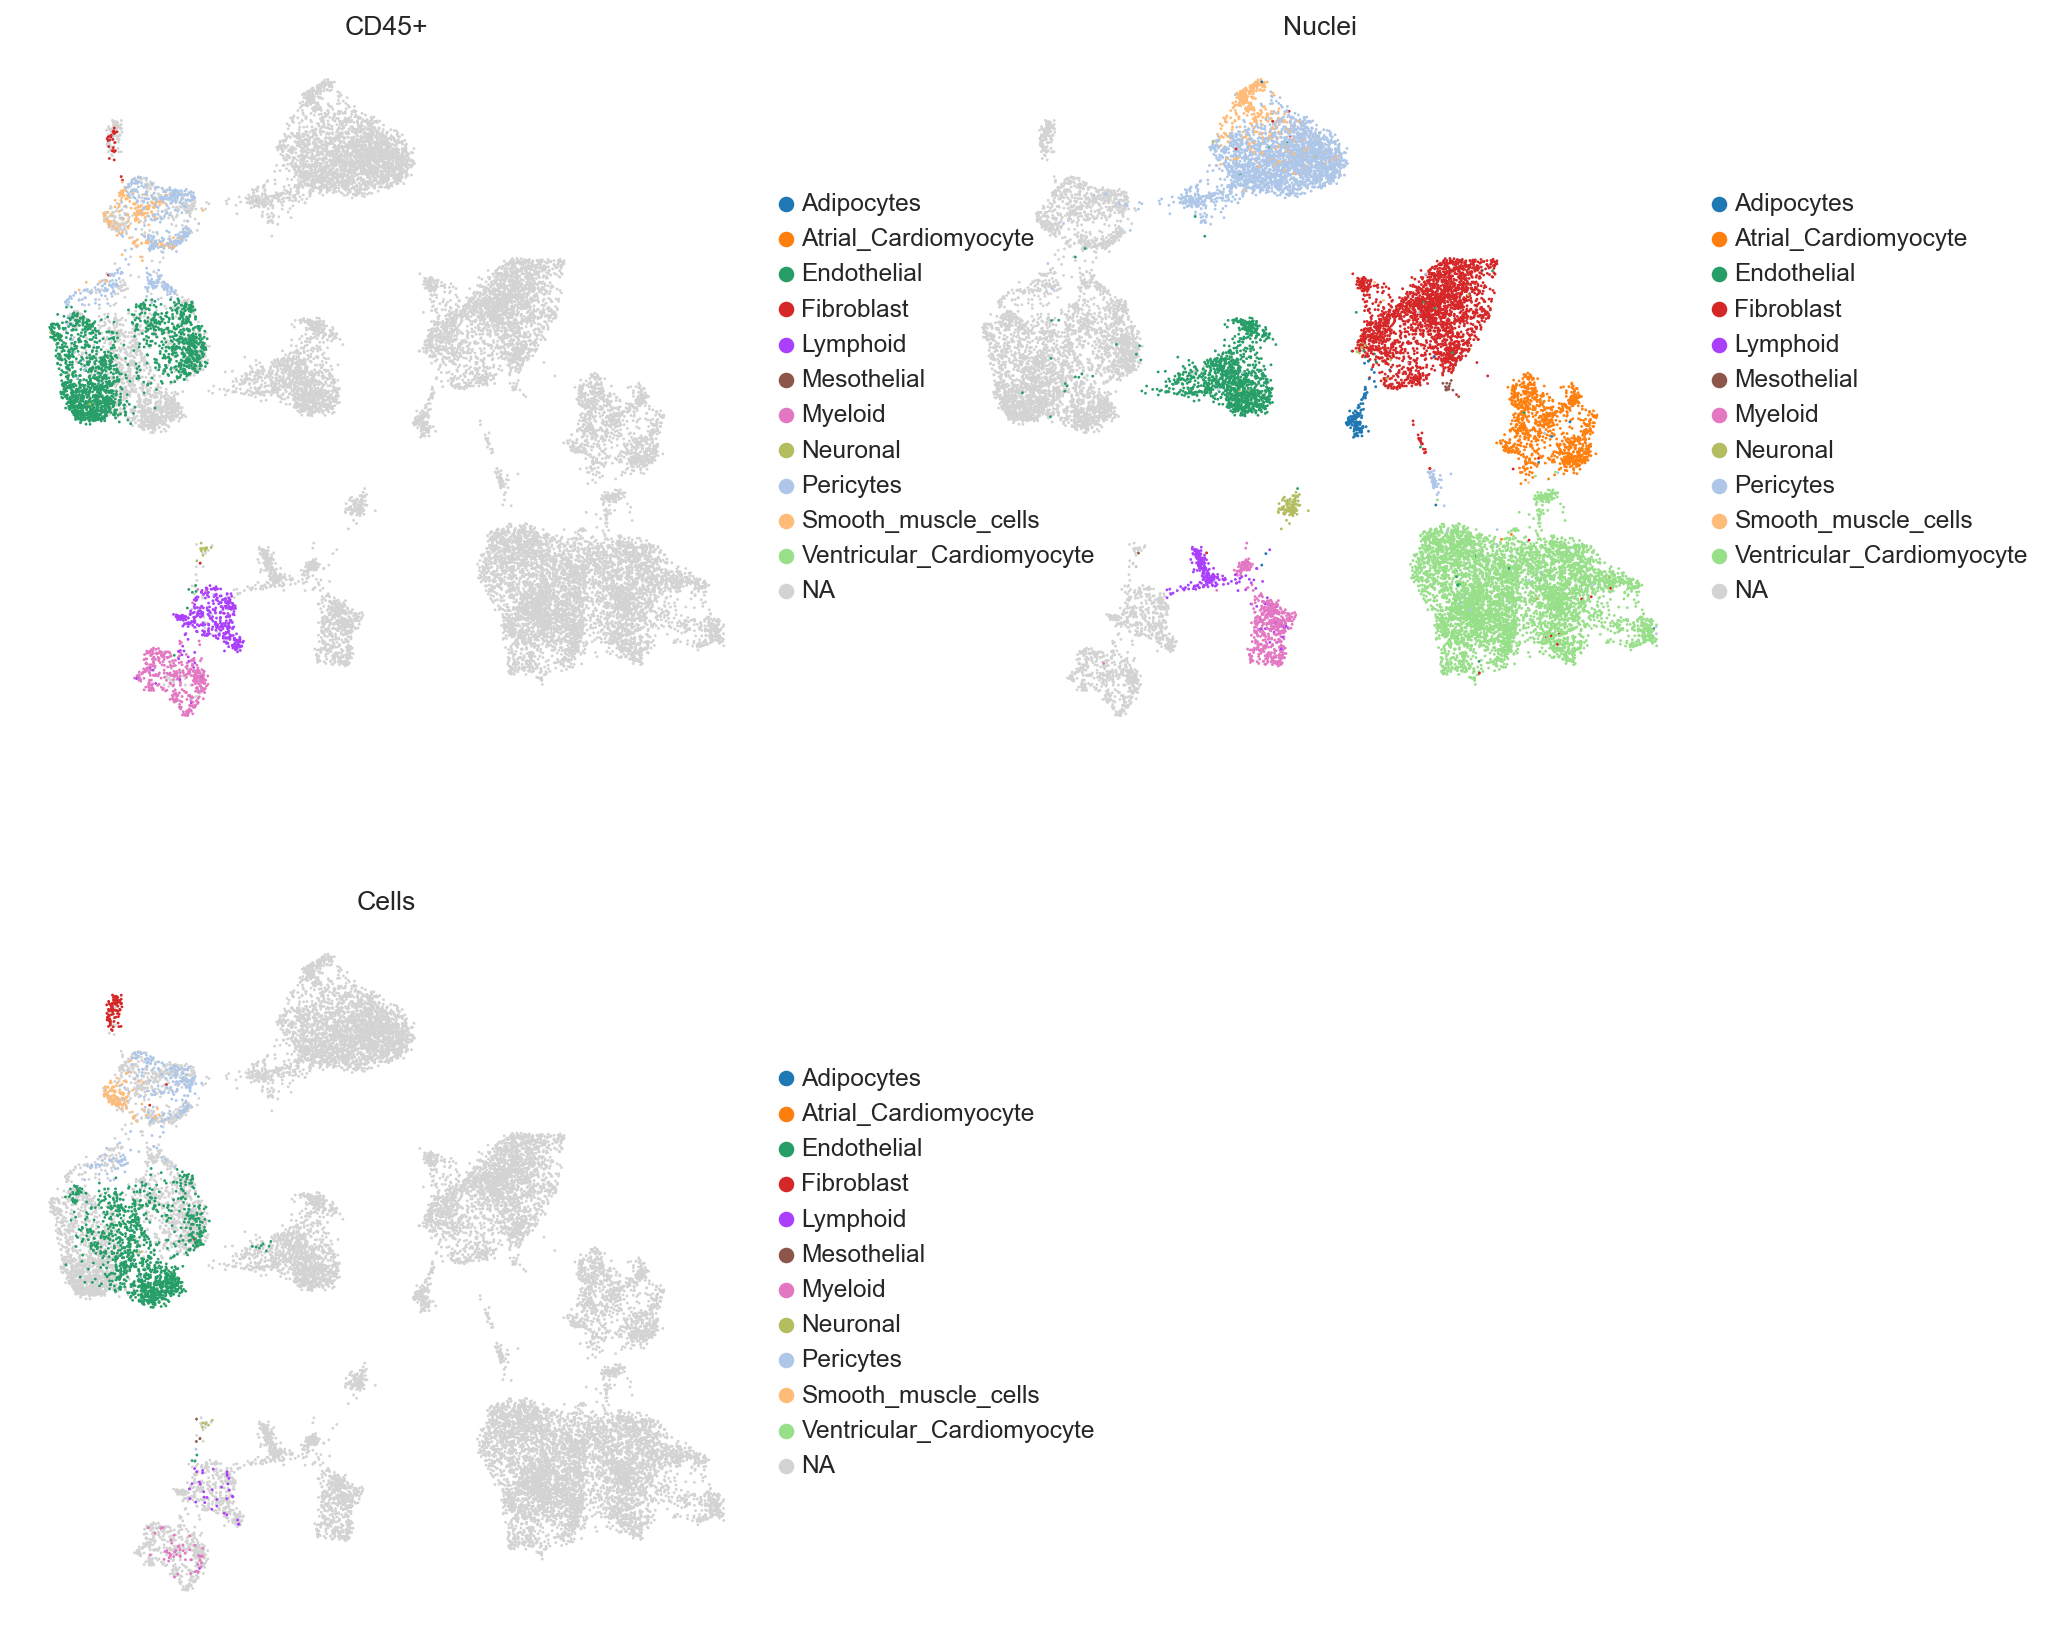

In [19]:
scp.pl.splitplot( 
    adata_scvi, 
    split_by="source", # Plots umap for each "source" separately
    colour_by="cell_type", # Colours each split umap by cell type
    ncols=2 # Lets you adjust how many columns to use in the plot
    )

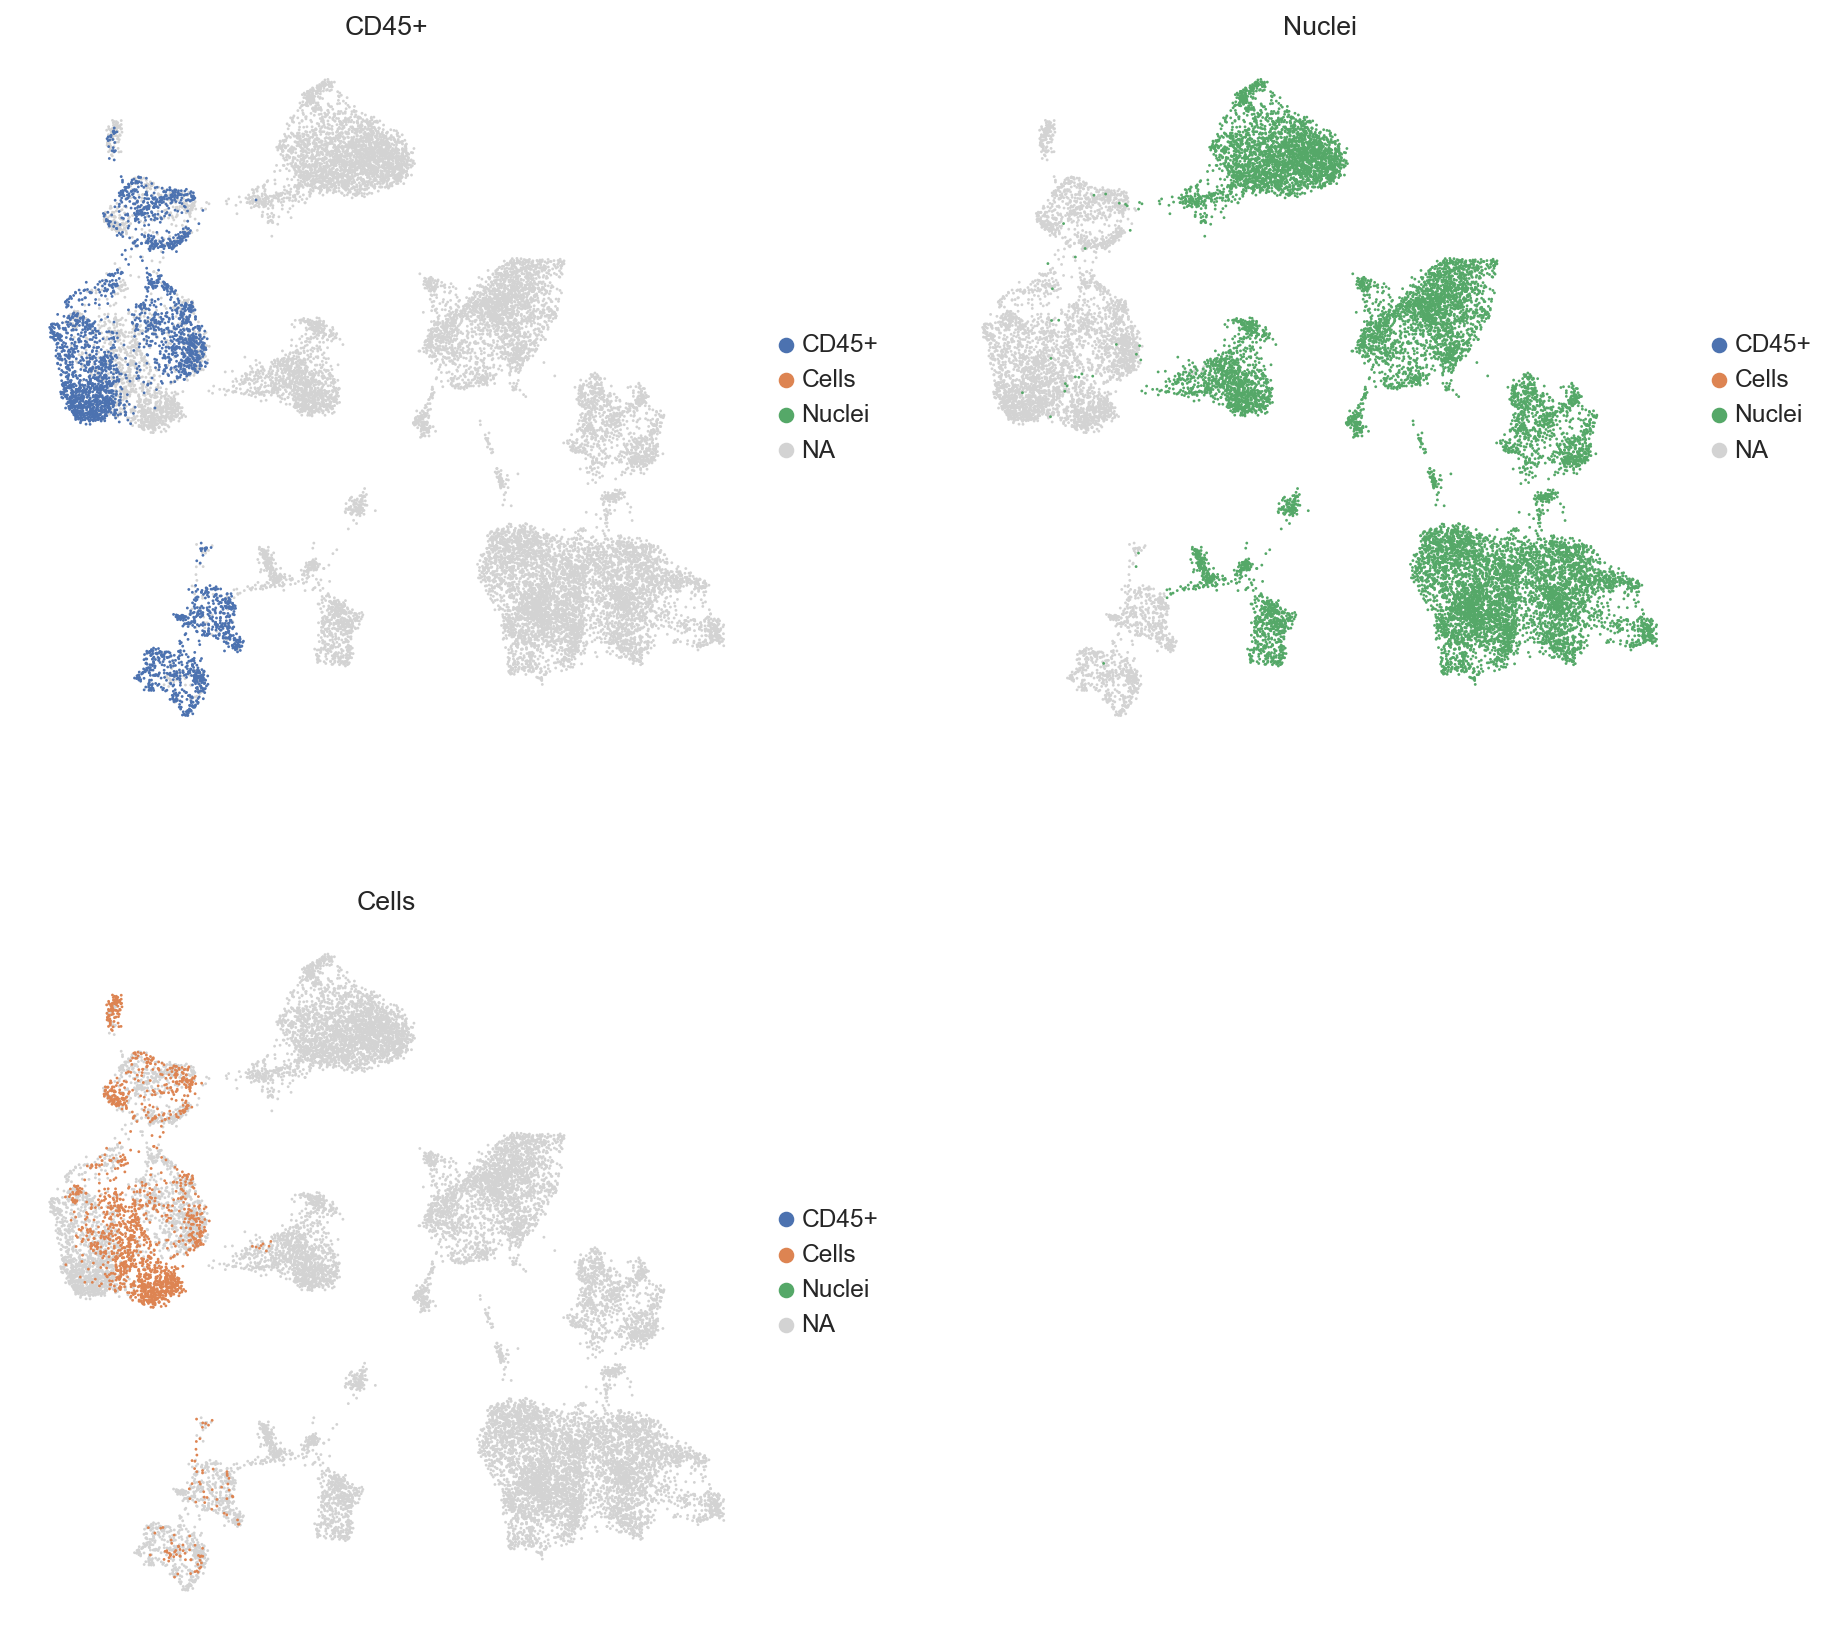

In [20]:
scp.pl.splitplot( 
    adata_scvi, 
    split_by="source", # Plots umap for each "source" separately
    colour_by="source", # Colours each split umap by cell type
    ncols=2 # Lets you adjust how many columns to use in the plot
    )

## Ridgeplot
A tool to replicate seurat ridgeplots

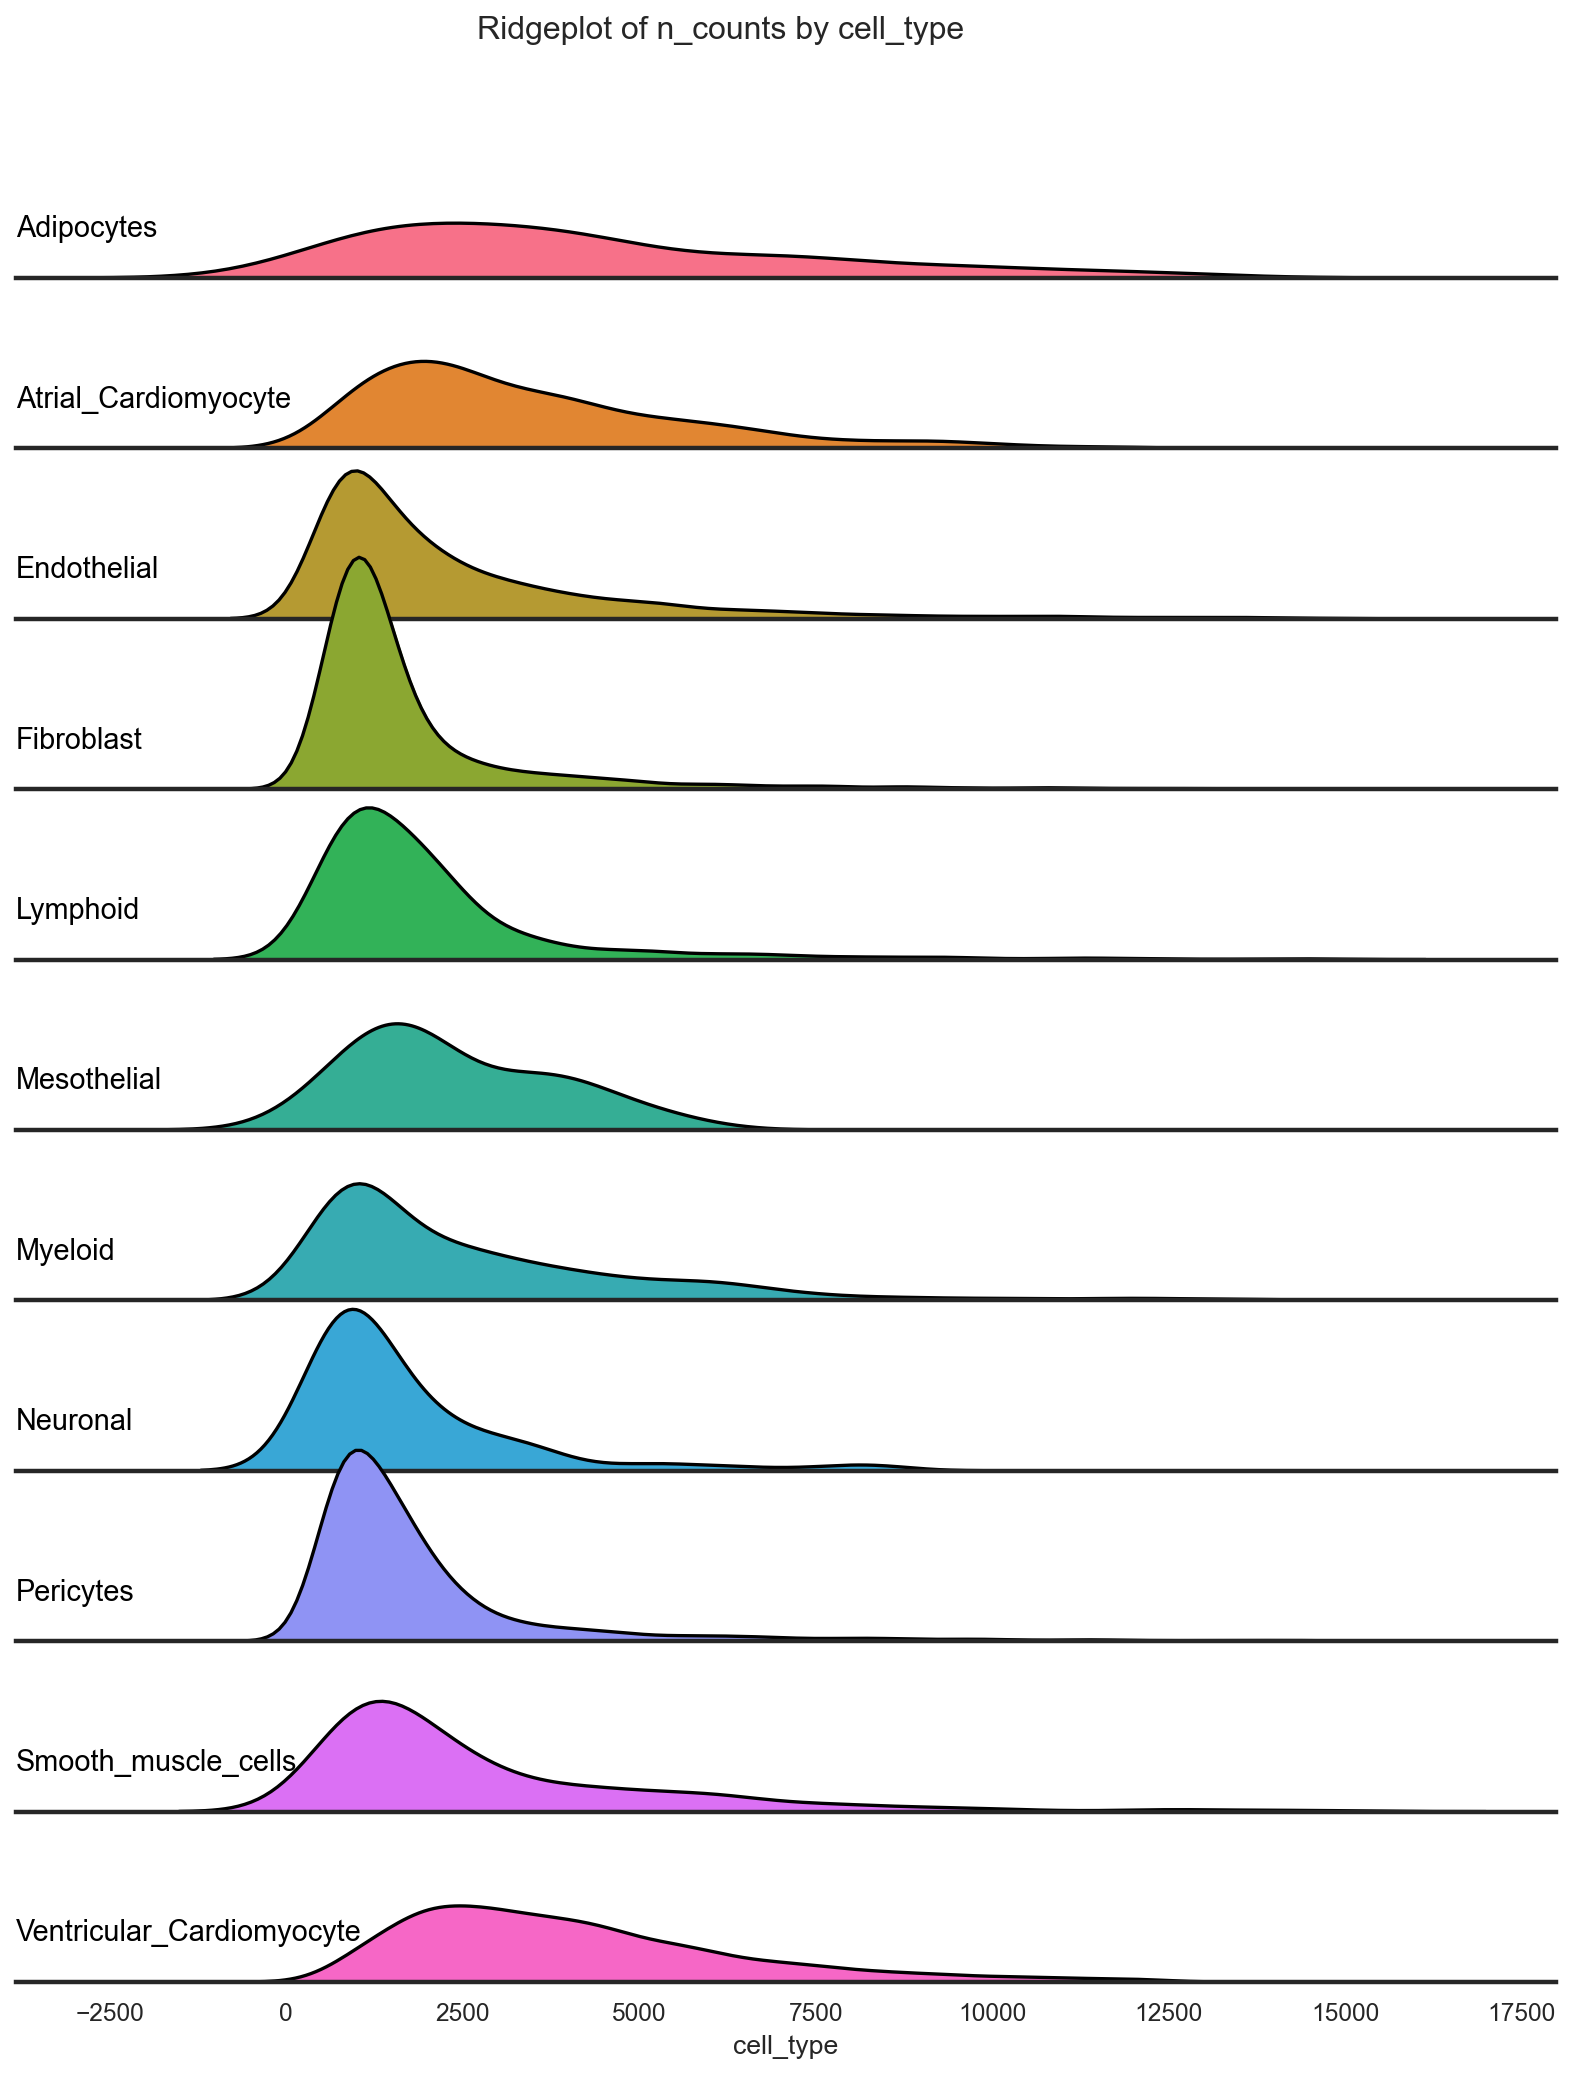

In [24]:
scp.pl.ridgeplot(adata_scvi, x = 'n_counts', split_by = 'cell_type', title = "Ridgeplot of n_counts by cell_type")

In [25]:
adata

AnnData object with n_obs × n_vars = 18641 × 2000
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'source_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [ ]:
scp.pl.splitscatter(adata, x='n_counts', y='n_genes', groupby="source", colorby='cell_type')